In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import ceil
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

***Funções de normalização dos dados***

In [ ]:
class NormalizedData:
  def normalized(X, min, max):
      return (X - min) / (max - min)

  def unnormalized(X, min, max):
      return X * (max - min) + min

  def z_score(X):
      mean = X.mean()
      std = X.std()
      out = (X - mean) / std
      return out

***Funções utilitárias***

In [ ]:
class UtilsData:
  def index(X, labels):
      n_cluster = len(np.bincount(labels))
      clusters = [X[labels == k] for k in range(n_cluster)]
      centroids = [np.mean(k, axis = 0) for k in clusters]
      scatters = [
          np.mean([
              np.linalg.norm(x - centroids[k]) for x in cluster
          ])
          for k, cluster in enumerate(clusters)
      ]

      maxs = []
      for k1 in range(n_cluster):
          results = []
          for k2 in range(n_cluster):
              if k1 != k2:
                  result = (scatters[k1] + scatters[k2]) / np.linalg.norm(centroids[k1] - centroids[k2])
                  results.append(result)
          maxs.append(max(results))

      return np.sum(maxs) / n_cluster

***Implementação da classe K-means***

In [ ]:
class Kmeans:
    def __init__(self, n_clusters=3, max_iter=30, distance_metric='euclidean'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.labels = None
        if distance_metric not in ['euclidean', 'mahalanobis']:
            raise Exception('Unknown distance metric')
        self.distance_metric = distance_metric

    def distance(self, a, b):
        if self.distance_metric == 'euclidean':
            return np.linalg.norm(a - b)
        else:
            return np.sqrt((a - b).T @ self.cov @ (a - b))

    def get_label(self, x):
        distances = np.apply_along_axis(lambda c: self.distance(x, c),
                                        axis=1,
                                        arr=self.centroids)
        return distances.argmin()

    def get_labels(self, X):
        return np.apply_along_axis(self.get_label, axis=1, arr=X)

    def get_reconstruction_error(self):
        result = 0
        for k in range(self.n_clusters):
            m_k = self.centroids[k]
            C_k = self.X[self.labels == k]
            distances = np.apply_along_axis(lambda x: self.distance(x, m_k),
                                            axis=1,
                                            arr=C_k)
            result += np.sum(distances)
        return result

    def fit_train(self, X):
        self.X = X
        self.X_min = X.min(axis=0)
        self.X_max = X.max(axis=0)
        self.X_norm = NormalizedData.normalized(X, self.X_min, self.X_max)

        if self.distance_metric == 'mahalanobis':
            self.cov = np.cov(self.X_norm.T)

        random_indices = np.random.choice(X.shape[0],
                                          size=self.n_clusters,
                                          replace=False)
        self.centroids = self.X_norm[random_indices, :]
        self.labels = self.get_labels(self.X_norm)

        changes_mean = float('inf')
        iters = 0
        while changes_mean > 0.001 and iters < self.max_iter:
            old_centroids = self.centroids.copy()
            for k in range(self.n_clusters):
                self.centroids[k,:] = self.X_norm[self.labels == k].mean(axis=0)
            changes_mean = np.abs((self.centroids - old_centroids).mean())
            self.labels = self.get_labels(self.X_norm)
            iters += 1

        self.centroids = NormalizedData.unnormalized(self.centroids, self.X_min, self.X_max)
        self.reconstruction_error = self.get_reconstruction_error()
        return self

    def predict(self, X):
        X_norm = NormalizedData.normalized(X, self.X_min, self.X_max)
        clusters = self.get_labels(X_norm)
        return clusters

In [ ]:
def plot_clusters(kmeans, data, ax):
    classified_data = [
        data[kmeans.labels == i]
        for i in range(kmeans.n_clusters)
    ]
    for X in classified_data:
        x = X[:, 0]
        y = X[:, 1]
        ax.plot(x, y, 'o')
    ax.plot(kmeans.centroids[:, 0], kmeans.centroids[:, 1], marker='o', linewidth=0, markeredgewidth=2, markeredgecolor='black', markerfacecolor='yellow')
    ax.set_title('%d Clusters | Índice DB = %.2f' % (kmeans.n_clusters, UtilsData.index(data, kmeans.labels)))

def plot_cluster_grid(kmeans, data, cols=4):
    fig, axs = plt.subplots(ceil(len(cluster_sizes) / cols), cols, figsize=(16, 16))
    for i, row in enumerate(axs):
        for j, ax in enumerate(row):
            index = i * cols + j
            if index < len(kmeans):
                km = kmeans[index]
                plot_clusters(km, data, ax)
            else:
                ax.set_visible(False)
    fig.tight_layout()

***Questão 01***

**ITEM (A)**

***Importando os Dados***

In [ ]:
df_quake = np.genfromtxt("quake.csv", delimiter=",")
#Os dados são normalizados dentro da função fit_train
X = df_quake

***K-médias com distância Euclidiana***

In [ ]:
kms = []
cluster_sizes = list(range(4, 21))
n_tries = 1

for k in tqdm(cluster_sizes):
    executions = [
        Kmeans(n_clusters=k, max_iter=30).fit_train(X)
        for _ in range(n_tries)
    ]
    km = min(executions, key=lambda x: x.reconstruction_error)
    kms.append(km)

100%|██████████| 17/17 [00:46<00:00,  2.75s/it]


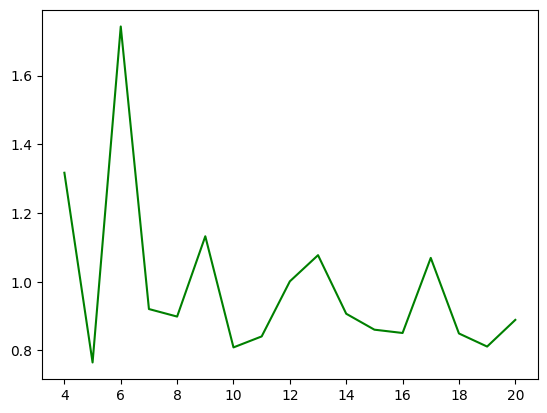

In [ ]:
r_euclidian = [UtilsData.index(X, km.labels) for km in kms]
x = list(range(4, 4 + len(kms)))
plt.plot(x, r_euclidian, 'g')

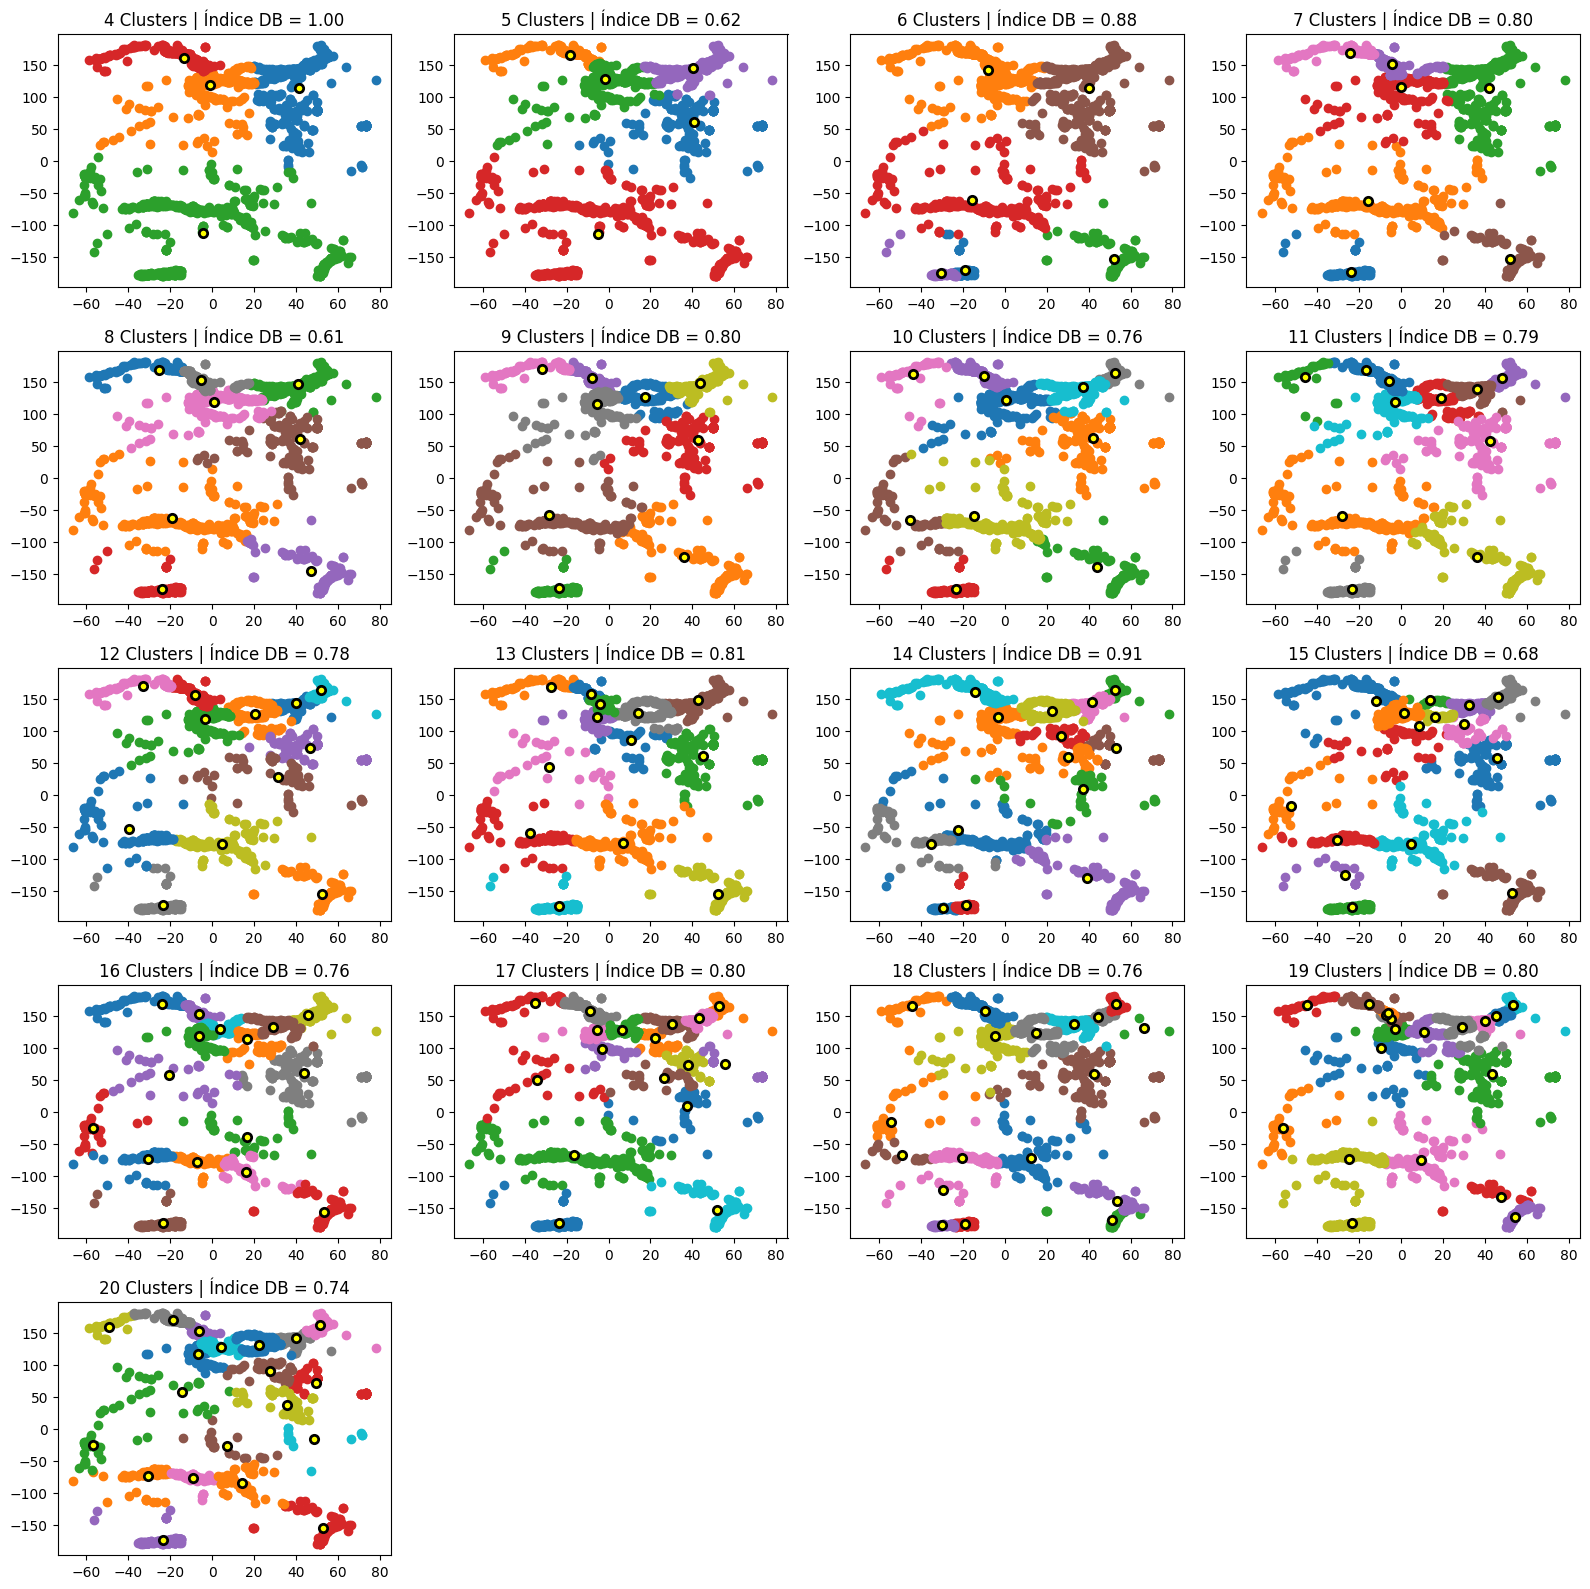

In [ ]:
plot_cluster_grid(kms, X)

**ITEM (B)**

***K-médias com distância de Mahalanobis***

In [ ]:
kms = []
for k in tqdm(cluster_sizes):
    executions = [
        Kmeans(n_clusters=k, max_iter=30, distance_metric='mahalanobis').fit_train(X)
        for _ in range(n_tries)
    ]
    km = min(executions, key=lambda x: x.reconstruction_error)
    kms.append(km)

100%|██████████| 17/17 [00:41<00:00,  2.43s/it]


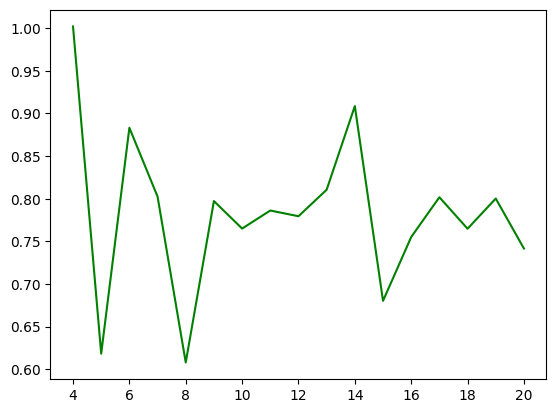

In [ ]:
r_mahalanobis = [UtilsData.index(X, km.labels) for km in kms]
x = list(range(4, 4 + len(kms)))
plt.plot(x, r_mahalanobis, 'g')

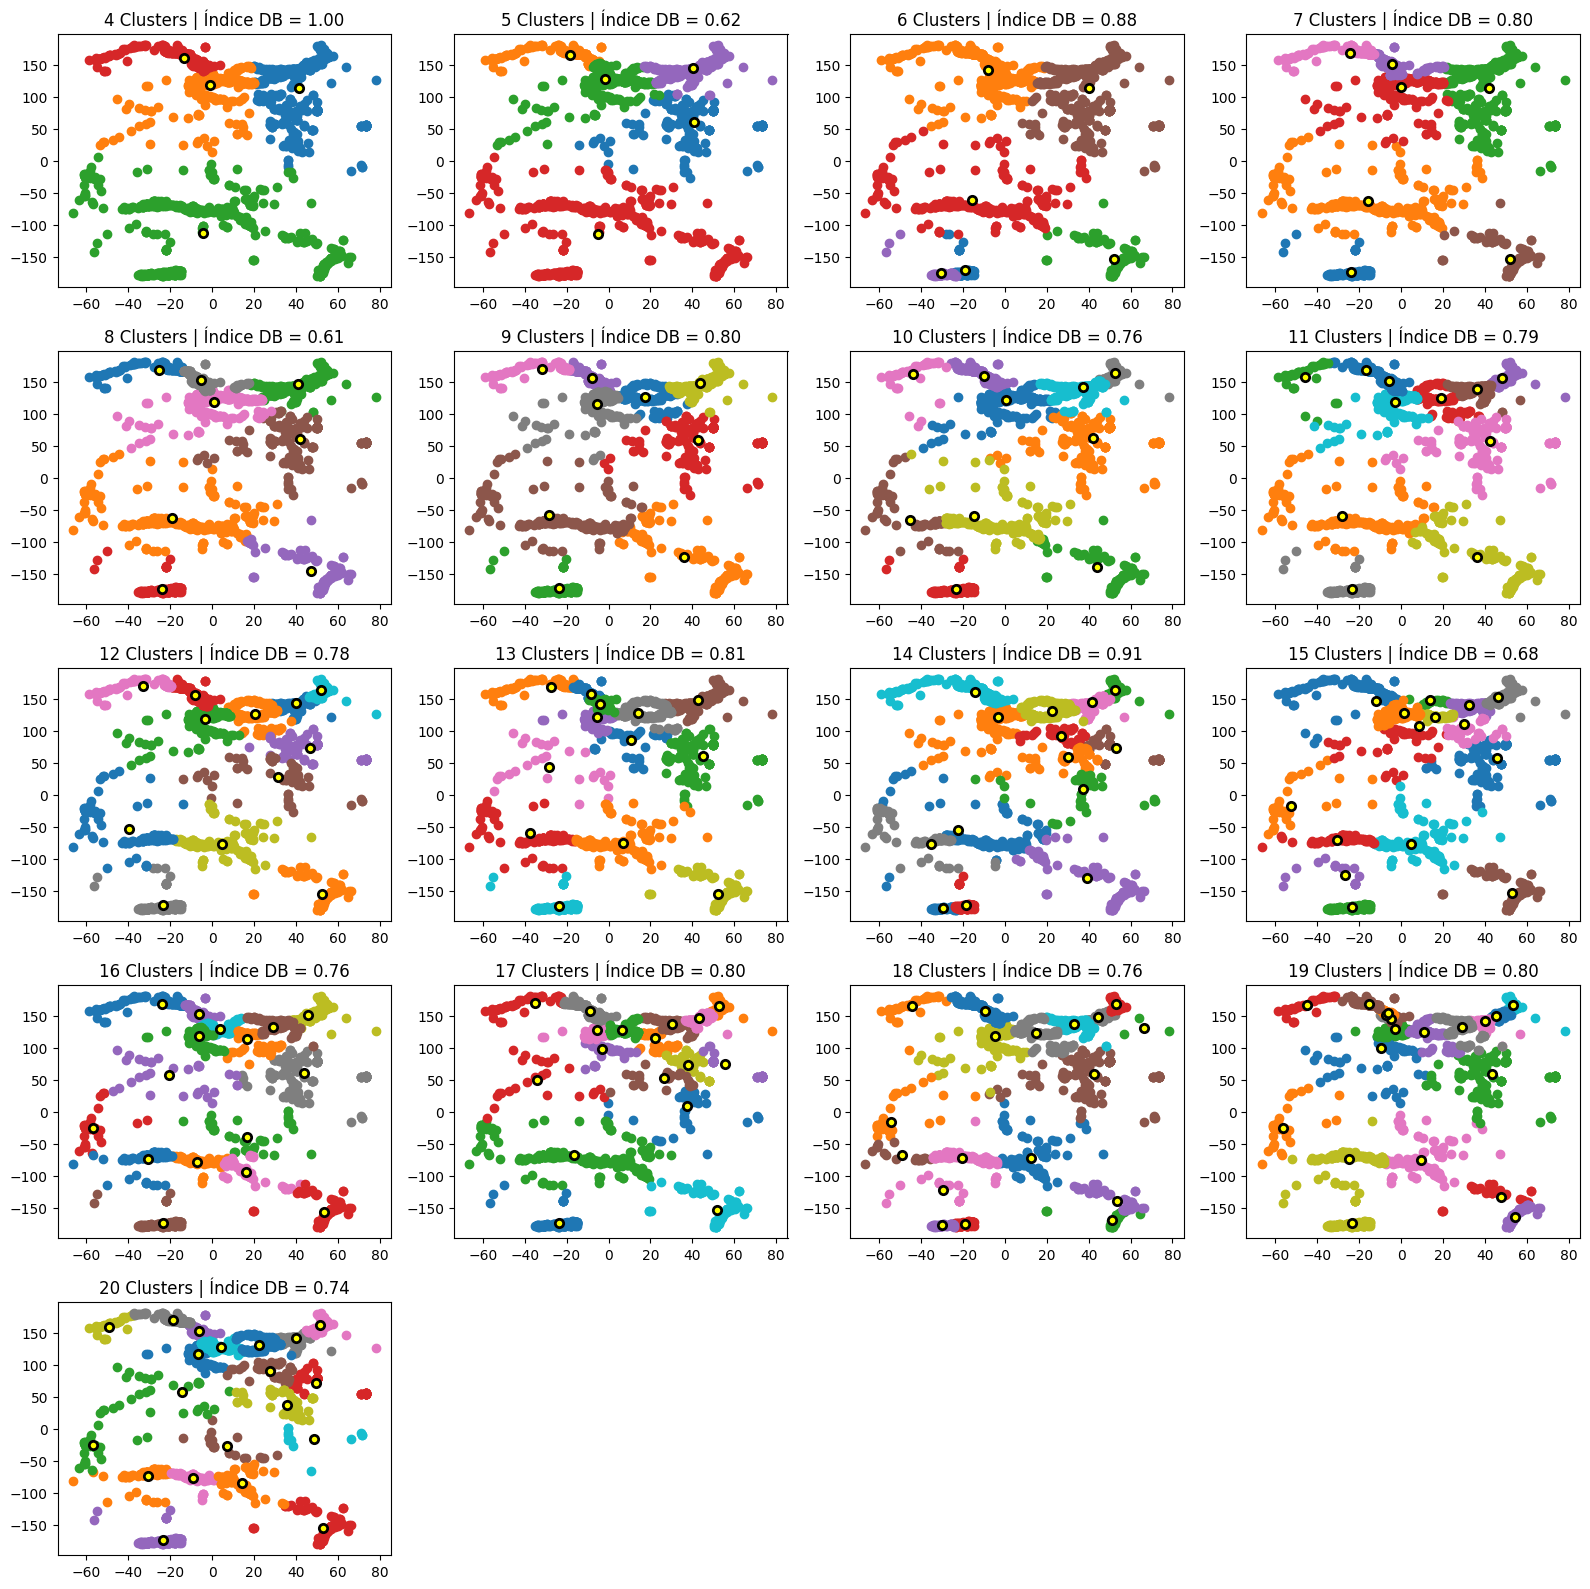

In [ ]:
plot_cluster_grid(kms, X)

***Questão 02***

***Implementação do PCA:***

In [ ]:
class PCA:
  def __init__(self, n_components):
      self.n_components = n_components

  def fit(self, X):
      cov = np.cov(X.T)
      u, s, _ = np.linalg.svd(cov)
      self.explained_variation = np.sum(s[:self.n_components] / np.sum(s))
      self.P = u[:,:self.n_components].T

  def transform(self, X):
      return (self.P @ X.T).T

  def fit_transform(self, X):
      self.fit(X)
      return self.transform(X)

**ITEM (A)**

***Importando os Dados***

In [ ]:
df_penguins = np.genfromtxt("penguins.csv", delimiter=",")

***Normalizando os dados***

In [ ]:
df_min = df_penguins.min(axis=0)
df_max = df_penguins.max(axis=0)
df_norm = NormalizedData.normalized(df_penguins, df_min, df_max)
X = df_norm[:, :-1]
y = df_norm[:, -1]

***PCA***

In [ ]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

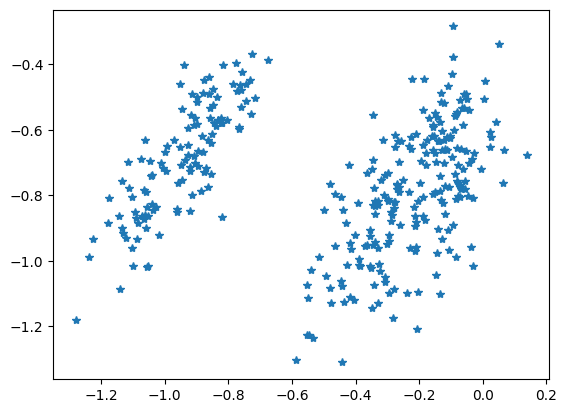

In [ ]:
x = X_reduced[:, 0]
y = X_reduced[:, 1]
plt.plot(x, y, '*')

**ITEM (B)**

***Gráfico da variância explicada por número de componentes***

In [ ]:
explained_variations = []
for i in range(1, 5):
    pca = PCA(n_components=i)
    pca.fit(X)
    explained_variations.append(pca.explained_variation)

([<matplotlib.axis.XTick at 0x7fdd339458a0>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

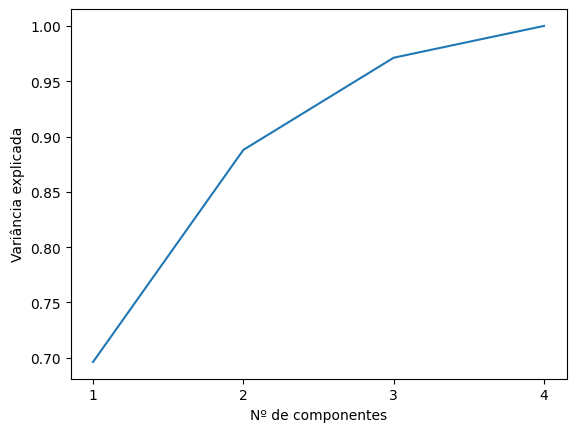

In [ ]:
x = list(range(1, 1 + len(explained_variations)))
plt.plot(x, explained_variations)
plt.xlabel('Nº de componentes')
plt.ylabel('Variância explicada')
plt.xticks(x, map(str, x))